In [24]:
import os
import gensim
import numpy as np
import collections
from pprint import pprint
import json
import re

'''
Yinuo Zhang, Isaac Duarte, Anthony Girard

This is the main model used for predicting the year of
a song based on its lyrics. Among the topics covered are 
Vector Embeddings, Regularization, Regular Expressions,
and Logistic Regression

First the data is loaded in and tokenized so that each song
is now a list of only the words in its lyrics. The data is then
split into a test and training set and word embeddings are created,
where each song is treated as the context of a word.

The classes are encoded to provide better labeling and song vectors are
created by averaging the word vectors of the lyrics per song. The
classes and song vectors are then passed into a logistic regression model
using l2 penalty which result in our final model.
'''

space = re.compile(r'\s')
period = re.compile(r'(?<![A-Z])\.|(?<!\w)\'(?!\w)')
punct = re.compile(r'[^\'#@\.\w]')

def tokenize(sent):
    sent = space.split(sent)
    to = []
    tokens = []
    for t in sent:
        if t:
            to += period.split(t)
    for t in to:
        if t:
            tokens += punct.split(t)
    return [a for a in tokens if a is not '']

def get_lyrics_years(songs):
    lyrics = []
    years = []
    
    for song_id in list(songs.keys()):
        yr = songs[song_id]["year"]
        if not yr or yr < 1940:
            continue
        lyrics.append(songs[song_id]["lyrics"].lower() + "\n{}\n{}".format(
                songs[song_id]["artist"], songs[song_id]["title"]))
        years.append(yr)
        
    return np.array(lyrics), np.array(years)

def doc_vec(doc):
    doc = [word for word in doc if word in w2v.wv.vocab]
    return np.mean(w2v[doc], axis=0)

def load_and_tokenize_data(path):
    songs_file = open(path, "r+")
    songs_dict = json.load(songs_file)

    lyrics, years = get_lyrics_years(songs_dict)
    tokenized_lyrics = []

    print("[Tokenizing lyrics]")
    for l in lyrics:
        tokenized_lyrics.append(tokenize(l))
    print("[Done]")
    
    return tokenized_lyrics, years

In [25]:
from sklearn.linear_model import LogisticRegression

def train_model(songs, years):
    x_train, x_dev, y_train, y_dev = train_test_split(songs, years, 
                                                      test_size=0.30, 
                                                      random_state=42)
    maxAcc = 0
    penaltyC = [10 ** i for i in range(-2, 2)]
    best_model = None
    for c in penaltyC:
        model = LogisticRegression(C=c, penalty="l2",
                                   solver='liblinear', 
                                   random_state=42,
                                   multi_class="auto")
        model.fit(x_train, y_train)
        acc = 100 * metrics.accuracy_score(y_dev, model.predict(x_dev))
        print(acc, maxAcc)
        if acc > maxAcc:
            best_model = model
            maxAcc = acc
                
    return best_model

In [29]:
import matplotlib.pyplot as plt

def plot_values(x_coord, y_coord, x_name, y_name, title):
    for i, y_points in enumerate(y_coord):
        plt.plot(x_coord, y_points, label=y_name[i])
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(title[1])
    plt.legend(loc='upper right')
    plt.show()

In [34]:
from sklearn import metrics
from collections import Counter

def test_and_print(x_test, y_test, model, lb, rng=5):
    y_pred = model.predict(x_test)
    y_pred = lb.inverse_transform(y_pred)
    
    print("\nModel Accuracy: %.3f" % metrics.accuracy_score(y_test, y_pred))
    #most Frequent Tag: 
    
    mfTags = [Counter(y_test).most_common(1)[0][0]]*len(y_test) 
    print("MostFreqTag Accuracy: %.3f" % metrics.accuracy_score(y_test, mfTags))
    
    prec, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred, 
                                                                            labels=lb.classes_)
    plot_values(lb.classes_, (prec, recall, fscore), "Year", ("Prec", "Recall", "F1"), 
               ("Accuracy for Years", "Percentage"))
    print(["Tag", "Prec", "Recall", "F1"])
    for i,c in enumerate(lb.classes_):
        print([c, "%.3f" % prec[i], "%.3f" % recall[i], "%.3f" % fscore[i]])
    
    y_pred = [(y // rng) * rng for y in y_pred]
    y_test = [(y // rng) * rng for y in y_test]
    
    classes = set([(y // rng) * rng for y in lb.classes_])
    
    rng_encoder = LabelEncoder()
    rng_encoder.fit_transform(list(classes))
    
    prec, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred, 
                                                                            labels=rng_encoder.classes_)
    plot_values(rng_encoder.classes_, (prec, recall, fscore), "Year Range", ("R-Prec", "R-Recall", "R-F1"), 
               ("Accuracy for Year Ranges", "Percentage"))
    print("Accuracies for ranges of length", rng)
    print(["Tag", "Prec", "Recall", "F1"])
    for i,c in enumerate(rng_encoder.classes_):
        print(str(c) + "-" + str(c + rng),
               "%.3f" % prec[i], "%.3f" % recall[i], "%.3f" % fscore[i])

In [ ]:
if __name__ == '__main__':
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.externals import joblib

    # Load the lyrics from the json and tokenize
    tokenized_lyrics, years = load_and_tokenize_data("songs/songs.json")
    
    # split into test and training set
    X_train, X_test, y_train, y_test = train_test_split(
                                tokenized_lyrics, years, test_size=0.33, random_state=42)
    
    # create word embeddings
    try:
        print("[Trying to load Word Embedding from file]")
        w2v = gensim.models.Word2Vec.load("model_out/embeddings.model")
        print("[Embeddings Loaded]")
    except Exception:
        print("[Creating Word Embeddings]")
        w2v = gensim.models.Word2Vec(X_train, size=350, window=10, min_count=3, iter=30)
        print("[Done: Saving Embeddings and printing out most similar words for 'money']")
        pprint(w2v.most_similar(['money']))
        w2v.save('model_out/embeddings.model')
    
    # encode years to fit model
    lb = LabelEncoder()
    y = lb.fit_transform(y_train)
    
    print("[Creating song embeddings]")
    # vector embeddings of songs
    song_vec_train = [doc_vec(song) for song in X_train]
    song_vec_test = [doc_vec(song) for song in X_test]
    
    try:
        print("[Trying to load model from file]")
        model = joblib.load("model_out/song2year.model")
    except Exception:
        print("[Training model]")
        model = train_model(song_vec_train, y)
        print("[Done: Now Saving Model]")
        joblib.dump(model, "model_out/song2year.model")    


Model Accuracy: 0.171
MostFreqTag Accuracy: 0.120
['Tag', 'Prec', 'Recall', 'F1']
[1979, '0.000', '0.000', '0.000']
[1980, '0.000', '0.000', '0.000']
[1981, '0.000', '0.000', '0.000']
[1982, '0.000', '0.000', '0.000']
[1983, '0.000', '0.000', '0.000']
[1984, '0.000', '0.000', '0.000']
[1985, '0.000', '0.000', '0.000']
[1986, '0.000', '0.000', '0.000']
[1987, '0.000', '0.000', '0.000']
[1988, '0.000', '0.000', '0.000']
[1989, '0.000', '0.000', '0.000']
[1990, '0.000', '0.000', '0.000']
[1991, '0.000', '0.000', '0.000']
[1992, '0.000', '0.000', '0.000']
[1993, '0.000', '0.000', '0.000']
[1994, '0.389', '0.222', '0.283']
[1995, '0.000', '0.000', '0.000']
[1996, '0.000', '0.000', '0.000']
[1997, '0.500', '0.023', '0.044']
[1998, '0.000', '0.000', '0.000']
[1999, '0.000', '0.000', '0.000']
[2000, '0.179', '0.060', '0.090']
[2001, '0.189', '0.086', '0.119']
[2002, '0.000', '0.000', '0.000']
[2003, '0.100', '0.051', '0.067']
[2004, '0.000', '0.000', '0.000']
[2005, '0.125', '0.041', '0.062']

c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


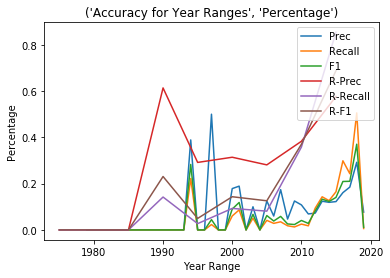

In [35]:
    test_and_print(song_vec_test, y_test, model, lb)